# Opdracht
## XML-dataset

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import time

xml_50000 = open('processen50000.xml', 'r').read()
xml_20000 = open('processen20000.xml', 'r').read()  # Read file
xml_10000 = open('processen10000.xml', 'r').read()
processentest = open('processentest.xml', 'r').read()
# root = ET.XML(xml_data)  # Parse XML

df_50000 = pd.read_xml(xml_50000)
df_20000 = pd.read_xml(xml_20000)
df_10000 = pd.read_xml(xml_10000)
df_test = pd.read_xml(processentest)

In [2]:
df_test.head()

,pid,arrivaltime,servicetime
0,1,0,3
1,2,2,6
2,3,4,4
3,4,6,5
4,5,8,2


De tijden zijn niet in seconden, maar in aantal JIFFY’s. Een JIFFY is de tijd tussen twee “system timer”-interrupts. Er kan enkel gescheduled worden, beslissen welk proces aan de beurt is, bij een interrupt. Hier is de waarde van de JIFFY 10 ms.

## Processtrategiën
FCFS, SJF, SRT, RR, HRRN, en multilevel feedback mode.

Van het FCFS, SJF, SRT en HRRN algoritme maak je 1 versie. Het RR algoritme wordt geïmplementeerd met time slices q = 2, q = 4 en q = 8.
Voor het multilevel feedback algoritme maak je twee versies, telkens met 5 wachtrijen. Maak hier zelf een goeie keuze voor de time slices per wachtrij.
Motiveer de keuze in het verslag. Uiteraard mag je er meer implementeren dan deze. Schenk bij de implementatie van deze strategiëen aandacht aan het ontwerp.
Indien de modellering goed verlopen is, zal je minder problemen hebben in deze fase.


## Evaluatie testresultaten

Voor het evalueren van de scheduler bepaal je aan de hand van een testrun een aantal grootheden:
- per proces: aankomsttijd, bedieningstijd , starttijd, eindtijd, omlooptijd, genormaliseerde omlooptijd en wachttijd
- globale parameters: gemiddelde omlooptijd, gemiddelde genormaliseerde omlooptijd en gemiddelde wachttijd

De resultaten breng je in twee grafieken:
- genormaliseerde omlooptijd in functie van bedieningstijd
- wachttijd in functie van bedieningstijd

De bedieningstijd verdeel je in percentielen. Voorbeeld voor 20000 processen: het eerste percentiel bestaat
uit de 200 kortste bedieningstijden.

In [3]:
# berekenen globale parameters:

def global_params(df, title):
    ''' functie voor de globale parameters bruikbaar voor elke strategie '''
    # gemiddelde omlooptijd:
    tat = df["TAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    normtat = df["normTAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    wait = df["waittime"].mean()

    params = (tat, normtat, wait)
    
    print("===================")
    print(title)
    print("===================")
    print ("gemiddelde omlooptijd bedraagt: "+ str(round(tat*10)) + "ms")
    print ("gemiddelde genormaliseerde omlooptijd bedraagt: "+ str(round(normtat,2)))
    print ("gemiddelde wachttijd bedraagt: "+ str(round(wait*10)) +"ms")
    return params

# params_fcfs = global_params(df_fcfs, "FCFS")
# params_fcfs

In [4]:
import numpy as np

# omzetten naar percentielen voor grafieken (we maken hier een functie die we kunnen herbruiken)
def df_to_perc(df):
    ''' turns a dataframe with x rows into one with 100 rows containing averages of every group of  x/100 rows of the original dataframe '''
    df_sort = df.sort_values('servicetime', axis = 0)
    df_perc = df_sort.groupby(np.arange(len(df_sort))//(len(df_sort)/100)).mean()
    df_fin = df_perc.drop(['pid','arrivaltime', 'starttime', 'TAT', 'endtime'], axis = 1)                            
    return df_fin

In [5]:
import matplotlib.pyplot as plt

def evaluate(df, title):
    ''' functie die de hele evaluatie maakt en uitprint van een dataframe die de nodige waarden bevat voor een scheduling strategie '''
    params = global_params(df, title)
    df_plot = df_to_perc(df)
    plt.plot(df_plot['servicetime'], df_plot['normTAT'])
    plt.xlabel('percentiel van bedieningstijd')
    plt.ylabel('genormaliseerde omlooptijd')
    plt.show()
    
    plt.plot(df_plot['servicetime'], df_plot['waittime'])
    plt.xlabel('percentiel van bedieningstijd')
    plt.ylabel('wachttijd [ms]')
    plt.show()
    
# evaluate(df_fcfs, "FCFS")
    


### FCFS
First Come First Served.
Implementatie: simpel, steeds bij de arrival time de service time optellen en kijken of het volgende proces heeft gewacht of niet.

De tijd nodig voor fcfs te schedulen is 0.3433113098144531
FCFS voor 10000 processen
gemiddelde omlooptijd bedraagt: 5407ms
gemiddelde genormaliseerde omlooptijd bedraagt: 26.94
gemiddelde wachttijd bedraagt: 4410ms


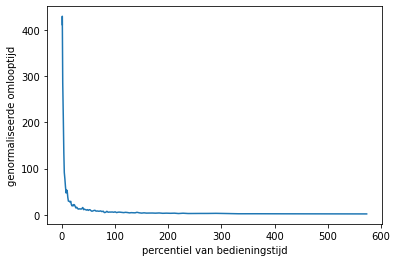

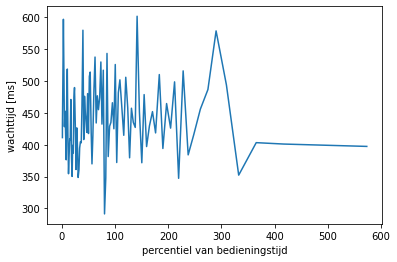

De tijd nodig voor fcfs te schedulen is 0.6503069400787354
FCFS voor 20000 processen
gemiddelde omlooptijd bedraagt: 5364ms
gemiddelde genormaliseerde omlooptijd bedraagt: 22.97
gemiddelde wachttijd bedraagt: 4356ms


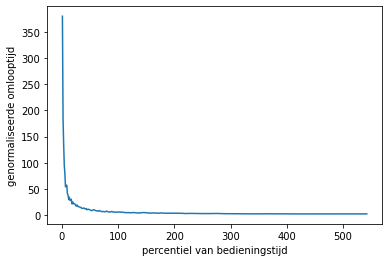

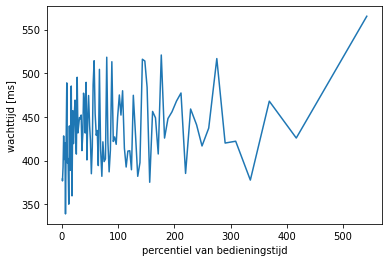

In [6]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
def FCFS(df):
    
    tijd = time.time()
    
    df_fcfs = df.copy()
    df_fcfs["starttime"] = df_fcfs["arrivaltime"]
    df_fcfs["waittime"] = 0
    df_fcfs["endtime"] = df_fcfs["arrivaltime"] + df_fcfs["servicetime"]

    for i in range(1, len(df_fcfs)):
        # als het proces toekomt alvorens het vorige proces klaar is (deze if loop is als het ware de scheduler):
        if df_fcfs.at[i-1, "endtime"] > df_fcfs.at[i, "arrivaltime"]: 
            # wachttijd berekenen
            df_fcfs.at[i, "waittime"] = df_fcfs.at[i-1, "endtime"] - df_fcfs.at[i, "arrivaltime"] 
            # starttijd bijstellen met wachttijd
            df_fcfs.at[i, "starttime"] = df_fcfs.at[i-1, "endtime"] 
        # eindtijd berekenen op basis van (aangepaste) starttijd en bedieningstijd
        df_fcfs.at[i, "endtime"] = df_fcfs.at[i, "starttime"] + df_fcfs.at[i, "servicetime"] 
    # Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
    df_fcfs["TAT"] = df_fcfs["servicetime"] + df_fcfs["waittime"]
    # idem voor de genormaliseerde TAT:
    df_fcfs["normTAT"] = df_fcfs["TAT"]/df_fcfs["servicetime"]
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig voor fcfs te schedulen is " + elapsed)
    
    return df_fcfs

evaluate(FCFS(df_10000), "FCFS voor 10000 processen")    
evaluate(FCFS(df_20000), "FCFS voor 20000 processen") 

### SJF
(In de cursus SPN = Shortest Process Next) </br>
Shortest Job First. Implementatie: telkens er overgegaan wordt op een ander proces, eerst steeds alle processen in wacht sorteren op service time, dan in volgorde uitvoeren.

De tijd nodig voor SJF te schedulen is 0.3628218173980713
SJF voor 10000 processen
gemiddelde omlooptijd bedraagt: 3017ms
gemiddelde genormaliseerde omlooptijd bedraagt: 6.28
gemiddelde wachttijd bedraagt: 2020ms


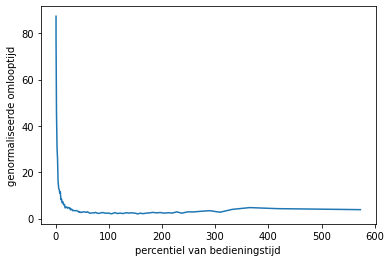

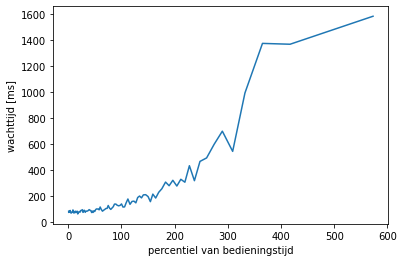

De tijd nodig voor SJF te schedulen is 0.7059516906738281
SJF voor 20000 processen
gemiddelde omlooptijd bedraagt: 2973ms
gemiddelde genormaliseerde omlooptijd bedraagt: 5.72
gemiddelde wachttijd bedraagt: 1965ms


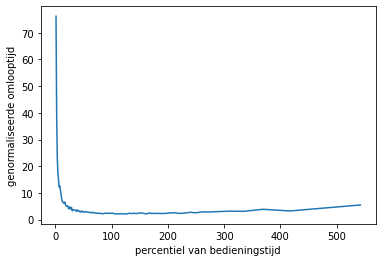

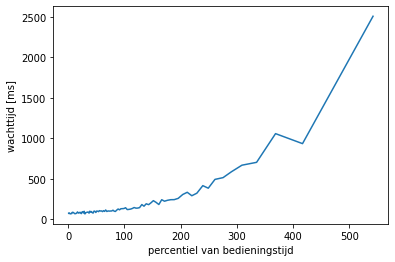

In [7]:
# take second element for sort
def takeSecond(elem):
    return elem[1]

def SJF(df):
    tijd = time.time()
    
    df_sjf = df.copy()
    df_sjf["starttime"] = -1
    df_sjf["waittime"] = 0
    df_sjf["endtime"] = 0
    
    df_sjf.sort_values('arrivaltime')  # sorteren op arrival time
    t = df_sjf.at[0, "arrivaltime"]
    queue = []
    last_index = 0
    
    while queue or (last_index != df_sjf.shape[0]):
        if last_index < len(df_sjf):
        # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue
            for i in range(last_index, df_sjf.shape[0]):
                if df_sjf.at[i, "arrivaltime"] <= t:
                    queue.append([i, df_sjf.at[i,"servicetime"]])
                else:
                    last_index = i
                    break
                # speciaal geval als het einde bereikt is:
                if i == df_sjf.shape[0]-1:
                    last_index = i+1
        
        # geval waarbij geen processen gearriveerd zijn
        if not queue:
            t = df_sjf.at[last_index, "arrivaltime"]
            queue.append([last_index, df_sjf.at[last_index,"servicetime"]])
            last_index = last_index + 1
        
        # sorteren op servicetime
        queue.sort(key=takeSecond)
        
        # proces met de kortste service time uitvoeren
        df_sjf.at[queue[0][0],"starttime"] = t
        df_sjf.at[queue[0][0],"waittime"] = df_sjf.at[queue[0][0],"starttime"] - df_sjf.at[queue[0][0],"arrivaltime"]
        t = t + queue[0][1]
        df_sjf.at[queue[0][0],"endtime"] = t
        queue.pop(0)
           
    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_sjf["waittime"] = df_sjf["waittime"] + (df_sjf["endtime"] - df_sjf["starttime"] - df_sjf["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_sjf["TAT"] = df_sjf["servicetime"] + df_sjf["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_sjf["normTAT"] = df_sjf["TAT"]/df_sjf["servicetime"]
    
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig voor SJF te schedulen is " + elapsed)
    return df_sjf

evaluate(SJF(df_10000), "SJF voor 10000 processen")    
evaluate(SJF(df_20000), "SJF voor 20000 processen")

### SRT
Shortest Remaining Time. Implementatie: opnieuw werken met een queue die steeds op de juiste momenten bepaalt welk proces het minste tijd resterend heeft.

De tijd nodig voor SRT te schedulen is 0.28225040435791016
SRT voor 10000 processen
gemiddelde omlooptijd bedraagt: 1402ms
gemiddelde genormaliseerde omlooptijd bedraagt: 1.15
gemiddelde wachttijd bedraagt: 405ms


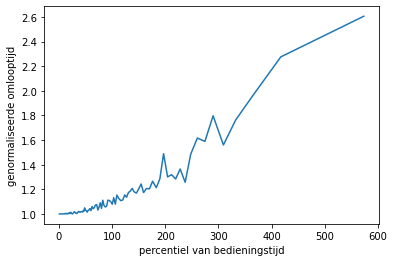

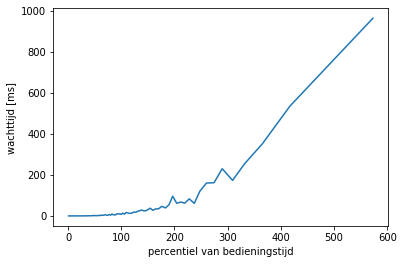

De tijd nodig voor SRT te schedulen is 0.5630025863647461
SRT voor 20000 processen
gemiddelde omlooptijd bedraagt: 1399ms
gemiddelde genormaliseerde omlooptijd bedraagt: 1.15
gemiddelde wachttijd bedraagt: 391ms


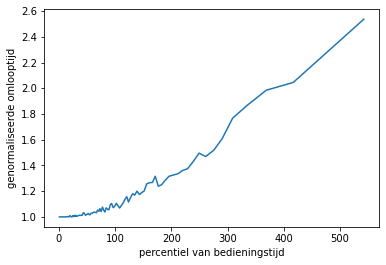

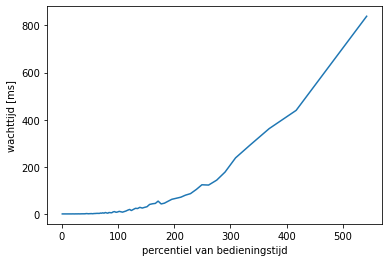

In [8]:
# take second element for sort
def takeSecond(elem):
    return elem[1]

def SRT(df):
    tijd = time.time()
    
    df_srt = df.copy()
    df_srt["starttime"] = -1
    df_srt["waittime"] = 0
    df_srt["endtime"] = 0
    # df_srt["rem_st"] = df_srt["servicetime"]  # extra kolom om de resterende service time bij te houden
    
    t = 0
    df_srt.sort_values('arrivaltime')  # sorteren op arrival time
    queue = []
    
    # beginnen bij het eerst gearriveerde proces
    for i in range(df_srt.shape[0]-1):
        t = df_srt.at[i, 'arrivaltime']
        # proces op de queue zetten
        queue.append([i,df_srt.at[i, 'servicetime']])
        # bij elke nieuwkomer opnieuw bekijken wat het proces is met het minst resterende tijd
        queue.sort(key=takeSecond)
        # berekenen van de tijd tot de volgende interrupt
        t_rest = df_srt.at[i+1, 'arrivaltime'] - t
        
        while t_rest > 0:
            # als proces nog niet gestart geef dan starttijd in
            if df_srt.at[queue[0][0],"starttime"] == -1:
                df_srt.at[queue[0][0],"starttime"] = t
                
            # als het proces volledig uitgevoerd kan worden:
            if t_rest >= queue[0][1]:
                t = t + queue[0][1]
                df_srt.at[queue[0][0],"endtime"] = t
                t_rest = t_rest - queue[0][1]
                queue.pop(0)
                # checken of dit het laatste element was in de queue:
                if not queue:
                    break # while loop breken
                    
            # als het proces niet volledig uitgevoerd kan worden    
            else:
                t = t + t_rest
                queue[0][1] = queue[0][1] - t_rest
                t_rest = 0
                break
    
    # laatste proces op de queue zetten
    queue.append([df_srt.shape[0]-1,df_srt.at[df_srt.shape[0]-1, 'servicetime']])
    # bij elke nieuwkomer opnieuw bekijken wat het proces is met het minst resterende tijd
    queue.sort(key=takeSecond)
    # als alles in de queue staat:
    while queue:
        # als proces nog niet gestart geef dan starttijd in
        if df_srt.at[queue[0][0],"starttime"] == -1:
            df_srt.at[queue[0][0],"starttime"] = t

        # Hier worden alle processen volledig uitgevoerd:
        t = t + queue[0][1]
        df_srt.at[queue[0][0],"endtime"] = t
        queue.pop(0)
        # checken of dit het laatste element was in de queue:
        if not queue:
            break # while loop breken
            
                
    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_srt["waittime"] = df_srt["waittime"] + (df_srt["endtime"] - df_srt["starttime"] - df_srt["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_srt["TAT"] = df_srt["servicetime"] + df_srt["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_srt["normTAT"] = df_srt["TAT"]/df_srt["servicetime"]
    
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig voor SRT te schedulen is " + elapsed)
    return df_srt

evaluate(SRT(df_10000), "SRT voor 10000 processen")    
evaluate(SRT(df_20000), "SRT voor 20000 processen")

### RR
Round Robin. Implementatie: Processor tijd wordt gelijk verdeelt onder alle processen die gearriveerd zijn tot ze. Werken met een queue waarop elk process aankomt en op de queue blijft tot het afgewerkt is.

De tijd nodig voor RR met q=2 te schedulen is 4.40565299987793
RR voor 10000 processen met q = 2
gemiddelde omlooptijd bedraagt: 5427ms
gemiddelde genormaliseerde omlooptijd bedraagt: 5.54
gemiddelde wachttijd bedraagt: 4431ms


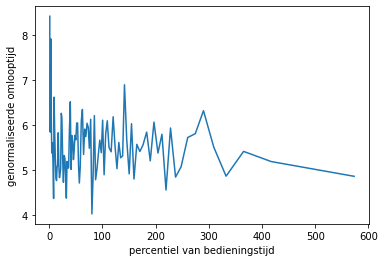

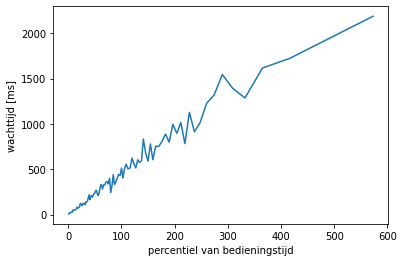

De tijd nodig voor RR met q=2 te schedulen is 9.79742693901062
RR voor 20000 processen met q = 2
gemiddelde omlooptijd bedraagt: 5440ms
gemiddelde genormaliseerde omlooptijd bedraagt: 5.39
gemiddelde wachttijd bedraagt: 4432ms


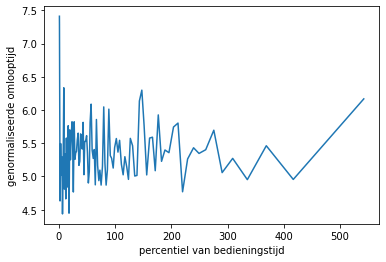

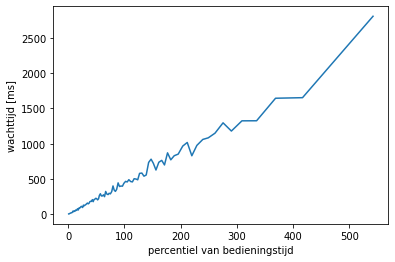

De tijd nodig voor RR met q=4 te schedulen is 3.2209458351135254
RR voor 10000 processen met q = 4
gemiddelde omlooptijd bedraagt: 5426ms
gemiddelde genormaliseerde omlooptijd bedraagt: 5.8
gemiddelde wachttijd bedraagt: 4430ms


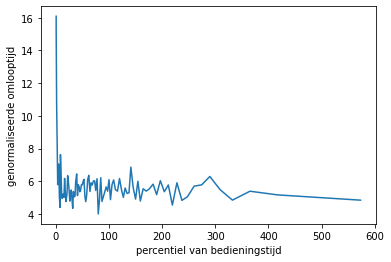

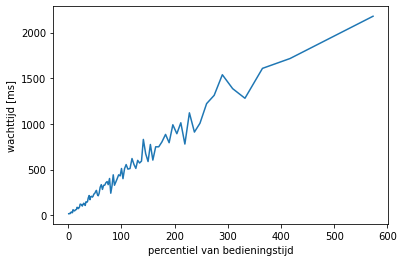

De tijd nodig voor RR met q=4 te schedulen is 6.286972999572754
RR voor 20000 processen met q = 4
gemiddelde omlooptijd bedraagt: 5439ms
gemiddelde genormaliseerde omlooptijd bedraagt: 5.6
gemiddelde wachttijd bedraagt: 4431ms


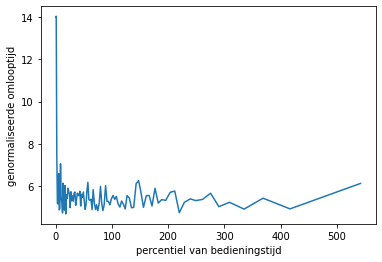

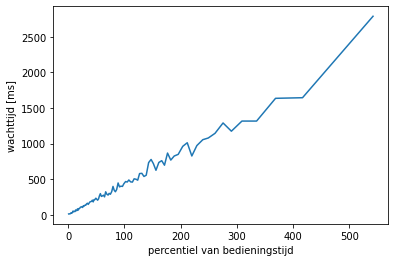

De tijd nodig voor RR met q=8 te schedulen is 1.781590223312378
RR voor 10000 processen met q = 8
gemiddelde omlooptijd bedraagt: 5427ms
gemiddelde genormaliseerde omlooptijd bedraagt: 6.4
gemiddelde wachttijd bedraagt: 4431ms


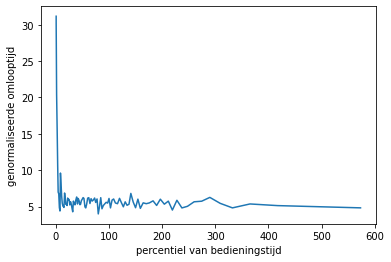

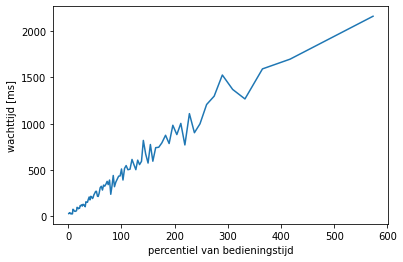

De tijd nodig voor RR met q=8 te schedulen is 3.628702402114868
RR voor 20000 processen met q = 8
gemiddelde omlooptijd bedraagt: 5437ms
gemiddelde genormaliseerde omlooptijd bedraagt: 6.06
gemiddelde wachttijd bedraagt: 4429ms


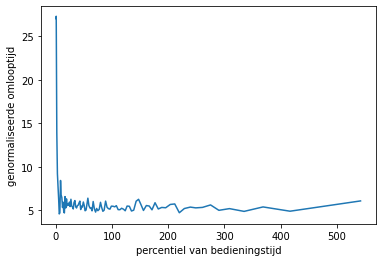

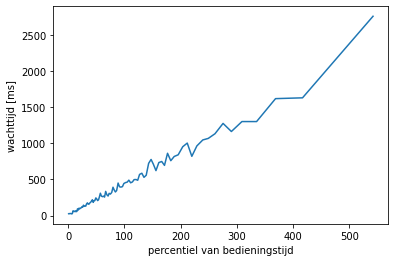

In [9]:
# RR implementatie

def RR(df, q):
    tijd = time.time()
    
    df_rr = df.copy()
    df_rr["starttime"] = -1
    df_rr["waittime"] = 0
    df_rr["endtime"] = 0
    # df_rr["rem_st"] = df_rr["servicetime"]  # extra kolom om de resterende service time bij te houden
    
    t = 0
    df_rr.sort_values('arrivaltime')  # sorteren op arrival time
    queue = []
    i=0
    j=0
    unfinished = False
    last_index = 0
    

    while queue or (last_index != df_rr.shape[0]):
        if last_index < len(df_rr):
        # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue
            for i in range(last_index, df_rr.shape[0]):
                if df_rr.at[i, "arrivaltime"] <= t:
                    queue.append([i, df_rr.at[i,"servicetime"]])
                else:
                    last_index = i
                    break
                # speciaal geval als het einde bereikt is:
                if i == df_rr.shape[0]-1:
                    last_index = i+1
                    
        # indien het laatste proces nog niet afgewerkt was plaatsen we dit nu achteraan:
        if unfinished:
            queue.append(queue.pop(0))
            unfinished = False
            
        # geval waarbij geen processen gearriveerd zijn
        if not queue:
            t = df_rr.at[last_index, "arrivaltime"]
            queue.append([last_index, df_rr.at[last_index,"servicetime"]])
            last_index = last_index + 1
            
        # proces vooraan queue voor q tijd uitvoeren:
        
        # als het proces voor de eerste keer aan de beurt is starttijd invullen
        if df_rr.at[queue[0][0], "starttime"] == -1:
            df_rr.at[queue[0][0], "starttime"] = t
            df_rr.at[queue[0][0],"waittime"] = df_rr.at[queue[0][0],"starttime"] - df_rr.at[queue[0][0],"arrivaltime"]

        # telkens gedurende q tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
        if queue[0][1] > q:    
            t = t + q
            queue[0][1] = queue[0][1] - q
            unfinished = True

        # Als er nog maar q of minder tijd rest, afwerken en van de queue halen
        else:
            t = t + queue[0][1]
            df_rr.at[queue[0][0], "endtime"] = t
            queue.pop(0)      
            

    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_rr["waittime"] = df_rr["waittime"] + (df_rr["endtime"] - df_rr["starttime"] - df_rr["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_rr["TAT"] = df_rr["servicetime"] + df_rr["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_rr["normTAT"] = df_rr["TAT"]/df_rr["servicetime"]
    
    
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig voor RR met q=" + str(q) + " te schedulen is " + str(elapsed))
    return df_rr

# RR(df_test, 4)
evaluate(RR(df_10000,2), "RR voor 10000 processen met q = 2")  
evaluate(RR(df_20000,2), "RR voor 20000 processen met q = 2")
evaluate(RR(df_10000,4), "RR voor 10000 processen met q = 4")    
evaluate(RR(df_20000,4), "RR voor 20000 processen met q = 4")
evaluate(RR(df_10000,8), "RR voor 10000 processen met q = 8")    
evaluate(RR(df_20000,8), "RR voor 20000 processen met q = 8")

### HRRN
Highest Response Ratio Next. Implementatie: we zullen werken met een extra kolom, response ratio, om op basis hiervan te kunnen sorteren. Eens een proces gestart is wordt het afgewerkt. We kunnen dus gelijkaardig te werk gaan als bij sjf, maar ipv op service time sorteren we nu op response ratio.

De tijd nodig voor HRRN te schedulen is 0.6733841896057129
HRRN voor 10000 processen
gemiddelde omlooptijd bedraagt: 3757ms
gemiddelde genormaliseerde omlooptijd bedraagt: 7.71
gemiddelde wachttijd bedraagt: 2761ms


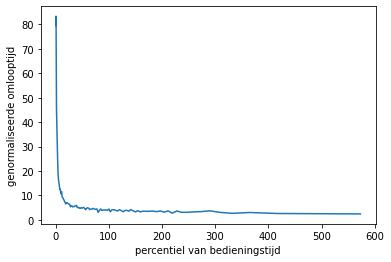

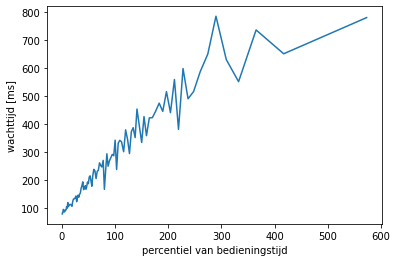

De tijd nodig voor HRRN te schedulen is 1.2504451274871826
HRRN voor 20000 processen
gemiddelde omlooptijd bedraagt: 3730ms
gemiddelde genormaliseerde omlooptijd bedraagt: 7.12
gemiddelde wachttijd bedraagt: 2723ms


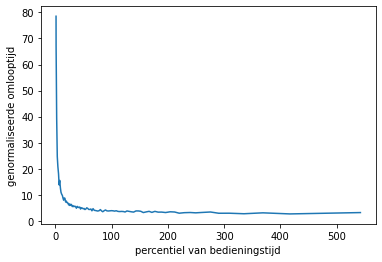

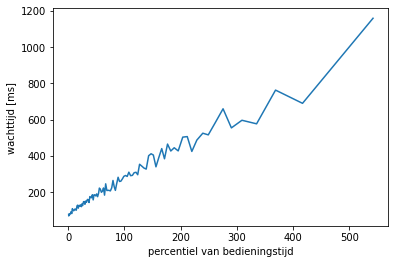

In [10]:
# take second element for sort
def takeSecond(elem):
    return elem[1]

def HRRN(df):
    tijd = time.time()
    
    df_hrrn = df.copy()
    df_hrrn["starttime"] = -1
    df_hrrn["waittime"] = 0
    df_hrrn["endtime"] = 0
    
    df_hrrn.sort_values('arrivaltime')  # sorteren op arrival time
    t = df_hrrn.at[0, "arrivaltime"]
    queue = []
    last_index = 0
    
    while queue or (last_index != df_hrrn.shape[0]):
        if last_index < len(df_hrrn):
        # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue
            for i in range(last_index, df_hrrn.shape[0]):
                if df_hrrn.at[i, "arrivaltime"] <= t:
                    queue.append([i, 0, df_hrrn.at[i,"servicetime"], df_hrrn.at[i,"waittime"]])
                else:
                    last_index = i
                    break
                # speciaal geval als het einde bereikt is:
                if i == df_hrrn.shape[0]-1:
                    last_index = i+1
        
        # geval waarbij geen processen gearriveerd zijn
        if not queue:
            t = df_hrrn.at[last_index, "arrivaltime"]
            queue.append([last_index, 0, df_hrrn.at[last_index,"servicetime"], df_hrrn.at[last_index,"waittime"]])
            last_index = last_index + 1
        # berekenen van de reeds gespendeerde wachttijd:
        for row in queue:
            row[3] = t - df_hrrn.at[row[0], "arrivaltime"]
        # berekenen van de response ratio:
        for row in queue:
            row[1] = (row[3]+row[2])/row[2]
        # sorteren op de berekende R
        queue.sort(key=takeSecond, reverse=True)
        
        # proces met hoogste R volledig uitvoeren:
        df_hrrn.at[queue[0][0],"starttime"] = t
        df_hrrn.at[queue[0][0],"waittime"] = df_hrrn.at[queue[0][0],"starttime"] - df_hrrn.at[queue[0][0],"arrivaltime"]
        t = t + queue[0][2]
        df_hrrn.at[queue[0][0],"endtime"] = t
        queue.pop(0)
           
    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_hrrn["waittime"] = df_hrrn["waittime"] + (df_hrrn["endtime"] - df_hrrn["starttime"] - df_hrrn["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_hrrn["TAT"] = df_hrrn["servicetime"] + df_hrrn["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_hrrn["normTAT"] = df_hrrn["TAT"]/df_hrrn["servicetime"]
    
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig voor HRRN te schedulen is " + elapsed)
    return df_hrrn

evaluate(HRRN(df_10000), "HRRN voor 10000 processen")    
evaluate(HRRN(df_20000), "HRRN voor 20000 processen")

### MLFB
MultiLevel FeedBack mode. Implementatie: (2 versies)

Versie 1: eenzelfde q voor elke queue

De tijd nodig om MLFB1 uit te voeren is 4.023975372314453
MLFB voor q=1
gemiddelde omlooptijd bedraagt: 5342ms
gemiddelde genormaliseerde omlooptijd bedraagt: 12.92
gemiddelde wachttijd bedraagt: 4335ms


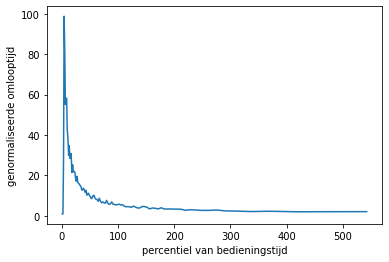

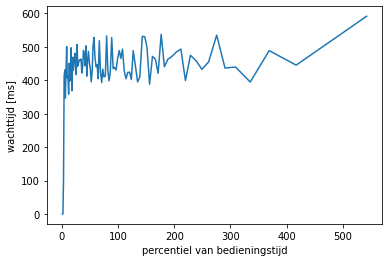

In [17]:
# MLFB implementatie 1:
def Q(queue, q, df, level, t_free, t):
    ''' hulpfunctie om de werking van een queue te emuleren als nog niet alle processen zijn opgenomen'''
    
    move = False
    
    if queue[0][2] == -1:
        queue[0][2] = q
                
    # rekening houden met t_free om te stoppen als een element op een hogere queue zou komen, maar ook bijhouden hoeveel tijd dit proces nog resteerd op de huidige queue
    if t_free < queue[0][2]:
        q_temp = t_free
        t_free = 0
        queue[0][2] = queue[0][2] - q_temp
    else:
        q_temp = queue[0][2]
        t_free = t_free - queue[0][2]
        queue[0][2] = 0
        
    # proces vooraan queue voor q_temp tijd uitvoeren:
    # telkens gedurende q_temp tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
    if queue[0][1] > q_temp:    
        t = t + q_temp
        queue[0][1] = queue[0][1] - q_temp
        if queue[0][2] == 0:
            queue[0][2] = -1
            move = True # als het proces niet afgewerkt kan worden doorschuiven naar de volgende queue

    # Als er nog maar q_temp of minder tijd rest, afwerken en van de queue halen
    else:
        t = t + queue[0][1]
        df.at[queue[0][0], "endtime"] = t
        df.at[queue[0][0], "priority"] = level
        queue.pop(0)
        
    return move, queue, df, t_free, t

def Q2(queue, q, df, level, t):
    ''' hulpfunctie om de werking van een queue te emuleren als alle processen zijn opgenomen'''
    
    move = False
    
    if queue[0][2] == -1:
        queue[0][2] = q
    
    q_temp = queue[0][2]
    queue[0][2] = 0
        
    # proces vooraan queue voor q_temp tijd uitvoeren:
    # telkens gedurende q_temp tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
    if queue[0][1] > q_temp:    
        t = t + q_temp
        queue[0][1] = queue[0][1] - q_temp
        if queue[0][2] == 0:
            queue[0][2] = -1
            move = True # als het proces niet afgewerkt kan worden doorschuiven naar de volgende queue

    # Als er nog maar q_temp of minder tijd rest, afwerken en van de queue halen
    else:
        t = t + queue[0][1]
        df.at[queue[0][0], "endtime"] = t
        df.at[queue[0][0], "priority"] = level
        queue.pop(0)
        
    return move, queue, df, t


def MLFB1(df, q):
    tijd = time.time()
    
    df_mlfb = df.copy()
    df_mlfb["starttime"] = -1
    df_mlfb["waittime"] = 0
    df_mlfb["endtime"] = 0
    df_mlfb["priority"] = -1
    
    t = 0
    df_mlfb.sort_values('arrivaltime')  # sorteren op arrival time
    queue0 = []
    queue1 = [] 
    queue2 = [] 
    queue3 = [] 
    queue4 = [] # FCFS queue
    i=0
    j=0
    last_index = 0
    move = False
    

    while last_index < len(df_mlfb):
        # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue
        for i in range(last_index, len(df_mlfb)):
            if df_mlfb.at[i, "arrivaltime"] <= t:
                queue0.append([i, df_mlfb.at[i,"servicetime"], -1]) # derde getal om eventueel resterende tijd op een niveau bij te houden
            else:
                last_index = i
                break
            # speciaal geval als het einde bereikt is:
            if i == len(df_mlfb)-1:
                last_index = i+1
        
        # tijd bepalen tot het volgende proces arriveert:
        if last_index != len(df_mlfb):
            t_free = df_mlfb.at[last_index, "arrivaltime"] - t
        else:
            t_free = 0
            
        # zolang er tijd is de queues afwerken in volgorde:       
        while queue0 and t_free > 0:
            # als het proces voor de eerste keer aan de beurt is starttijd invullen
            if df_mlfb.at[queue0[0][0], "starttime"] == -1:
                df_mlfb.at[queue0[0][0], "starttime"] = t
                df_mlfb.at[queue0[0][0],"waittime"] = df_mlfb.at[queue0[0][0],"starttime"] - df_mlfb.at[queue0[0][0],"arrivaltime"]

            # 1 proces draaien op de queue
            [move, queue0, df_mlfb, t_free, t] = Q(queue0, q, df_mlfb, 0, t_free, t)
            # print(["0", move, queue0, t_free, t])
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue1.append(queue0.pop(0))

            # stoppen als de tijd op is
            if t_free == 0:
                break

        while queue1 and t_free > 0:
            [move, queue1, df_mlfb, t_free, t] = Q(queue1, q, df_mlfb, 1, t_free, t)
            # print(["1", move, queue1, t_free, t])
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue2.append(queue1.pop(0))

            # stoppen als de tijd op is
            if t_free == 0:
                break

        while queue2 and t_free > 0:
            [move, queue2, df_mlfb, t_free, t] = Q(queue2, q, df_mlfb, 2, t_free, t)
            # print(["2", move, queue2, t_free, t])
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue3.append(queue2.pop(0))

            # stoppen als de tijd op is
            if t_free <= 0:
                break

        while queue3 and t_free > 0:
            [done, queue3, df_mlfb, t_free, t] = Q(queue3, q, df_mlfb, 3, t_free, t)
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue4.append(queue3.pop(0))

            # stoppen als de tijd op is
            if t_free <= 0:
                break

        while queue4 and t_free > 0:
            # deze queue moet gewoon blijven uitvoeren als een RR queue
            [done, queue4, df_mlfb, t_free, t] = Q(queue4, q, df_mlfb, 4, t_free, t)
            if move:
                move = False
                queue4.append(queue4.pop(0))

            # stoppen als de tijd op is
            if t_free <= 0:
                break 
                
        if t_free > 0:
            # als alle queues leeg zijn:
            t = df_mlfb.at[last_index,"arrivaltime"]
            queue0.append([last_index, df_mlfb.at[last_index,"servicetime"], -1])
            last_index = last_index + 1     

    # alle queues in volgorde afwerken:
    while queue0:
        # als het proces voor de eerste keer aan de beurt is starttijd invullen
        if df_mlfb.at[queue0[0][0], "starttime"] == -1:
            df_mlfb.at[queue0[0][0], "starttime"] = t
            df_mlfb.at[queue0[0][0],"waittime"] = df_mlfb.at[queue0[0][0],"starttime"] - df_mlfb.at[queue0[0][0],"arrivaltime"]

        # 1 proces draaien op de queue
        [move, queue0, df_mlfb, t] = Q2(queue0, q, df_mlfb, 0, t)
        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue1.append(queue0.pop(0))
            move = False

    while queue1:
        [move, queue1, df_mlfb, t] = Q2(queue1, q, df_mlfb, 1, t)
        
        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue2.append(queue1.pop(0))
            move = False

    while queue2:
        [move, queue2, df_mlfb, t] = Q2(queue2, q, df_mlfb, 2, t)

        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue3.append(queue2.pop(0))
            move = False

    while queue3:
        [done, queue3, df_mlfb, t] = Q2(queue3, q, df_mlfb, 3, t)

        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue4.append(queue3.pop(0))
            move = False

    while queue4:
        # deze queue moet gewoon blijven uitvoeren als een RR queue
        [done, queue4, df_mlfb, t] = Q2(queue4, q, df_mlfb, 4, t)

        if move:
            queue4.append(queue4.pop(0))
            move = False
            

    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_mlfb["waittime"] = df_mlfb["waittime"] + (df_mlfb["endtime"] - df_mlfb["starttime"] - df_mlfb["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_mlfb["TAT"] = df_mlfb["servicetime"] + df_mlfb["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_mlfb["normTAT"] = df_mlfb["TAT"]/df_mlfb["servicetime"]
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig om MLFB1 uit te voeren is " + elapsed)
    
    return df_mlfb

evaluate(MLFB1(df_20000,1), "MLFB voor q=1")

Versie 2: elke queue een andere quantum<br/>
Een optie voor 4 quantums vinden we door de service times in 5 delen te verdelen en van elk deel het gemiddelde te nemen.<br/>
Dit geeft ons : 10, 36, 70, 120, 260<br/>
Ronden we deze gemiddeldes nu af dan zien we waarden als 10, 40, 80. We beslissen na een aantal tests om als q's volgende waarden te nemen: 5,10,20,40,80

In [18]:
df_sort = df_50000.sort_values('servicetime', axis = 0)
df_perc = df_sort.groupby(np.arange(len(df_sort))//(len(df_sort)/5)).mean()
df_perc.head(5)

,pid,arrivaltime,servicetime
0.0,24985.4262,3.107384e+06,10.2934
1.0,24876.4015,3.093656e+06,35.6397
2.0,25107.2520,3.122315e+06,69.6580
3.0,24907.2706,3.097363e+06,121.3614
4.0,25126.1497,3.124614e+06,260.6736


De tijd nodig om MLFB2 uit te voeren is 1.1939647197723389
MLFB voor q=2^i
gemiddelde omlooptijd bedraagt: 5423ms
gemiddelde genormaliseerde omlooptijd bedraagt: 4.17
gemiddelde wachttijd bedraagt: 4415ms


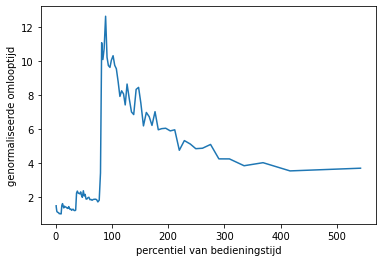

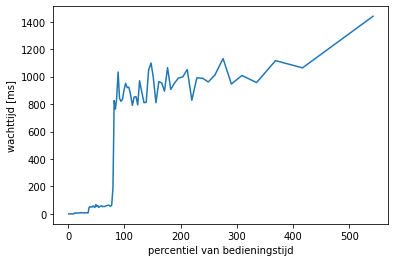

In [37]:
# MLFB implementatie 2:
def Q(queue, q, df, level, t_free, t):
    ''' hulpfunctie om de werking van een queue te emuleren als nog niet alle processen zijn opgenomen'''
    
    move = False
    
    if queue[0][2] == -1:
        queue[0][2] = q
                
    # rekening houden met t_free om te stoppen als een element op een hogere queue zou komen, maar ook bijhouden hoeveel tijd dit proces nog resteerd op de huidige queue
    if t_free < queue[0][2]:
        q_temp = t_free
        t_free = 0
        queue[0][2] = queue[0][2] - q_temp
    else:
        q_temp = queue[0][2]
        t_free = t_free - queue[0][2]
        queue[0][2] = 0
        
    # proces vooraan queue voor q_temp tijd uitvoeren:
    # telkens gedurende q_temp tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
    if queue[0][1] > q_temp:    
        t = t + q_temp
        queue[0][1] = queue[0][1] - q_temp
        if queue[0][2] == 0:
            queue[0][2] = -1
            move = True # als het proces niet afgewerkt kan worden doorschuiven naar de volgende queue

    # Als er nog maar q_temp of minder tijd rest, afwerken en van de queue halen
    else:
        t = t + queue[0][1]
        df.at[queue[0][0], "endtime"] = t
        df.at[queue[0][0], "priority"] = level
        queue.pop(0)
        
    return move, queue, df, t_free, t

def Q2(queue, q, df, level, t):
    ''' hulpfunctie om de werking van een queue te emuleren als alle processen zijn opgenomen'''
    
    move = False
    
    if queue[0][2] == -1:
        queue[0][2] = q
    
    q_temp = queue[0][2]
    queue[0][2] = 0
        
    # proces vooraan queue voor q_temp tijd uitvoeren:
    # telkens gedurende q_temp tijd laten lopen en afhankelijk van de resterende benodigde tijd afhandelen
    if queue[0][1] > q_temp:    
        t = t + q_temp
        queue[0][1] = queue[0][1] - q_temp
        if queue[0][2] == 0:
            queue[0][2] = -1
            move = True # als het proces niet afgewerkt kan worden doorschuiven naar de volgende queue

    # Als er nog maar q_temp of minder tijd rest, afwerken en van de queue halen
    else:
        t = t + queue[0][1]
        df.at[queue[0][0], "endtime"] = t
        df.at[queue[0][0], "priority"] = level
        queue.pop(0)
        
    return move, queue, df, t


def MLFB2(df, q0, q1, q2, q3, q4):
    tijd = time.time()
    
    df_mlfb = df.copy()
    df_mlfb["starttime"] = -1
    df_mlfb["waittime"] = 0
    df_mlfb["endtime"] = 0
    df_mlfb["priority"] = -1
    
    t = 0
    df_mlfb.sort_values('arrivaltime')  # sorteren op arrival time
    queue0 = []
    queue1 = [] 
    queue2 = [] 
    queue3 = [] 
    queue4 = [] # FCFS queue
    i=0
    j=0
    last_index = 0
    move = False
    

    while last_index < len(df_mlfb):
        # Alle processen die in de tussentijd zijn gearriveerd toevoegen aan de queue
        for i in range(last_index, len(df_mlfb)):
            if df_mlfb.at[i, "arrivaltime"] <= t:
                queue0.append([i, df_mlfb.at[i,"servicetime"], -1]) # derde getal om eventueel resterende tijd op een niveau bij te houden
            else:
                last_index = i
                break
            # speciaal geval als het einde bereikt is:
            if i == len(df_mlfb)-1:
                last_index = i+1
        
        # tijd bepalen tot het volgende proces arriveert:
        if last_index != len(df_mlfb):
            t_free = df_mlfb.at[last_index, "arrivaltime"] - t
        else:
            t_free = 0
            
        # zolang er tijd is de queues afwerken in volgorde:       
        while queue0 and t_free > 0:
            # als het proces voor de eerste keer aan de beurt is starttijd invullen
            if df_mlfb.at[queue0[0][0], "starttime"] == -1:
                df_mlfb.at[queue0[0][0], "starttime"] = t
                df_mlfb.at[queue0[0][0],"waittime"] = df_mlfb.at[queue0[0][0],"starttime"] - df_mlfb.at[queue0[0][0],"arrivaltime"]

            # 1 proces draaien op de queue
            [move, queue0, df_mlfb, t_free, t] = Q(queue0, q0, df_mlfb, 0, t_free, t)
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue1.append(queue0.pop(0))

            # stoppen als de tijd op is
            if t_free == 0:
                break

        while queue1 and t_free > 0:
            [move, queue1, df_mlfb, t_free, t] = Q(queue1, q1, df_mlfb, 1, t_free, t)
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue2.append(queue1.pop(0))

            # stoppen als de tijd op is
            if t_free == 0:
                break

        while queue2 and t_free > 0:
            [move, queue2, df_mlfb, t_free, t] = Q(queue2, q2, df_mlfb, 2, t_free, t)
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue3.append(queue2.pop(0))

            # stoppen als de tijd op is
            if t_free <= 0:
                break

        while queue3 and t_free > 0:
            [done, queue3, df_mlfb, t_free, t] = Q(queue3, q3, df_mlfb, 3, t_free, t)
            # daar waar nodig doorschuiven naar volgende queue:
            if move:
                move = False
                queue4.append(queue3.pop(0))

            # stoppen als de tijd op is
            if t_free <= 0:
                break

        while queue4 and t_free > 0:
            # deze queue moet gewoon blijven uitvoeren als een RR queue
            [done, queue4, df_mlfb, t_free, t] = Q(queue4, q4, df_mlfb, 4, t_free, t)
            if move:
                move = False
                queue4.append(queue4.pop(0))

            # stoppen als de tijd op is
            if t_free <= 0:
                break 
                
        if t_free > 0:
            # als alle queues leeg zijn:
            t = df_mlfb.at[last_index,"arrivaltime"]
            queue0.append([last_index, df_mlfb.at[last_index,"servicetime"], -1])
            last_index = last_index + 1     

    # alle queues in volgorde afwerken:
    while queue0:
        # als het proces voor de eerste keer aan de beurt is starttijd invullen
        if df_mlfb.at[queue0[0][0], "starttime"] == -1:
            df_mlfb.at[queue0[0][0], "starttime"] = t
            df_mlfb.at[queue0[0][0],"waittime"] = df_mlfb.at[queue0[0][0],"starttime"] - df_mlfb.at[queue0[0][0],"arrivaltime"]

        # 1 proces draaien op de queue
        [move, queue0, df_mlfb, t] = Q2(queue0, q0, df_mlfb, 0, t)
        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue1.append(queue0.pop(0))
            move = False

    while queue1:
        [move, queue1, df_mlfb, t] = Q2(queue1, q1, df_mlfb, 1, t)
        
        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue2.append(queue1.pop(0))
            move = False

    while queue2:
        [move, queue2, df_mlfb, t] = Q2(queue2, q2, df_mlfb, 2, t)

        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue3.append(queue2.pop(0))
            move = False

    while queue3:
        [done, queue3, df_mlfb, t] = Q2(queue3, q3, df_mlfb, 3, t)

        # daar waar nodig doorschuiven naar volgende queue:
        if move:
            queue4.append(queue3.pop(0))
            move = False

    while queue4:
        # deze queue moet gewoon blijven uitvoeren als een RR queue
        [done, queue4, df_mlfb, t] = Q2(queue4, q4, df_mlfb, 4, t)

        if move:
            queue4.append(queue4.pop(0))
            move = False
            

    # Als de queue volledig is afgewerkt doen we nog de laatste berekeningen:
    ## we stellen de wait time bij, wacht tijd - start tijd - service tijd komt overeen met de tijd gespendeerd in wacht na de start
    df_mlfb["waittime"] = df_mlfb["waittime"] + (df_mlfb["endtime"] - df_mlfb["starttime"] - df_mlfb["servicetime"])
    ## we berekenen de TAT zoals gezien in de les: service time + wait time    
    df_mlfb["TAT"] = df_mlfb["servicetime"] + df_mlfb["waittime"]
    ## idem voor de genormaliseerde TAT:
    df_mlfb["normTAT"] = df_mlfb["TAT"]/df_mlfb["servicetime"]
    
    elapsed = str(time.time()-tijd)
    print("De tijd nodig om MLFB2 uit te voeren is " + elapsed)
    
    return df_mlfb

evaluate(MLFB2(df_20000,10,26,44,50,140), "MLFB voor q=2^i")

Een verbetering op deze implementatie zou zijn om los van de gekozen q voor elke queue ook nog een RR time slice te kiezen voor elke queue. Dit zou toelaten om een hogere q voor elke queue te kiezen zonder de korte processen te benadelen.

De tijd nodig voor fcfs te schedulen is 0.34816884994506836
De tijd nodig voor SJF te schedulen is 0.3680150508880615
De tijd nodig voor SRT te schedulen is 0.2836902141571045
De tijd nodig voor RR met q=2 te schedulen is 4.273968458175659
De tijd nodig voor RR met q=4 te schedulen is 2.368225336074829
De tijd nodig voor RR met q=8 te schedulen is 1.364487886428833
De tijd nodig voor HRRN te schedulen is 0.4906458854675293
De tijd nodig om MLFB1 uit te voeren is 0.8956971168518066
De tijd nodig om MLFB2 uit te voeren is 0.5954058170318604


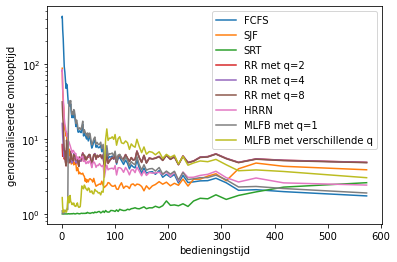

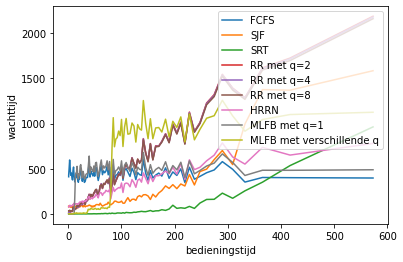

In [34]:
# Totaal grafiek:
def totaal(df, title):
    fcfs = df_to_perc(FCFS(df))
    sjf = df_to_perc(SJF(df))
    srt = df_to_perc(SRT(df))
    rr2 = df_to_perc(RR(df, 2))
    rr4 = df_to_perc(RR(df, 4))
    rr8 = df_to_perc(RR(df, 8))
    hrrn = df_to_perc(HRRN(df))
    mlfb1 = df_to_perc(MLFB1(df, 4))
    mlfb2 = df_to_perc(MLFB2(df, 10,26,44,50,140))
    
    plt.plot(fcfs['servicetime'], fcfs['normTAT'])
    plt.plot(sjf['servicetime'], sjf['normTAT'])
    plt.plot(srt['servicetime'], srt['normTAT'])
    plt.plot(rr2['servicetime'], rr2['normTAT'])
    plt.plot(rr4['servicetime'], rr4['normTAT'])
    plt.plot(rr8['servicetime'], rr8['normTAT'])
    plt.plot(hrrn['servicetime'], hrrn['normTAT'])
    plt.plot(mlfb1['servicetime'], mlfb1['normTAT'])
    plt.plot(mlfb2['servicetime'], mlfb2['normTAT'])
    plt.xlabel('bedieningstijd')
    plt.ylabel('genormaliseerde omlooptijd')
    #plt.ylim(0,100)
    plt.yscale('log')
    plt.legend(["FCFS", "SJF", "SRT", "RR met q=2", "RR met q=4", "RR met q=8", "HRRN", "MLFB met q=1", "MLFB met verschillende q"])
    plt.savefig(title+"1.svg", format = 'svg')
    plt.show()

    plt.plot(fcfs['servicetime'], fcfs['waittime'])
    plt.plot(sjf['servicetime'], sjf['waittime'])
    plt.plot(srt['servicetime'], srt['waittime'])
    plt.plot(rr2['servicetime'], rr2['waittime'])
    plt.plot(rr4['servicetime'], rr4['waittime'])
    plt.plot(rr8['servicetime'], rr8['waittime'])
    plt.plot(hrrn['servicetime'], hrrn['waittime'])
    plt.plot(mlfb1['servicetime'], mlfb1['waittime'])
    plt.plot(mlfb2['servicetime'], mlfb2['waittime'])
    plt.xlabel('bedieningstijd')
    plt.ylabel('wachttijd')
    plt.yscale('linear')
    plt.legend(["FCFS", "SJF", "SRT", "RR met q=2", "RR met q=4", "RR met q=8", "HRRN", "MLFB met q=1", "MLFB met verschillende q"])
    plt.savefig(title+"2.svg", format = 'svg')
    plt.show()
    
    return

totaal(df_10000, "df_10000")

De tijd nodig voor fcfs te schedulen is 0.6527421474456787
De tijd nodig voor SJF te schedulen is 0.6990995407104492
De tijd nodig voor SRT te schedulen is 0.5415422916412354
De tijd nodig voor RR met q=2 te schedulen is 9.147145509719849
De tijd nodig voor RR met q=4 te schedulen is 5.99319314956665
De tijd nodig voor RR met q=8 te schedulen is 3.3959133625030518
De tijd nodig voor HRRN te schedulen is 1.179839849472046
De tijd nodig om MLFB1 uit te voeren is 2.2445499897003174
De tijd nodig om MLFB2 uit te voeren is 1.5154190063476562


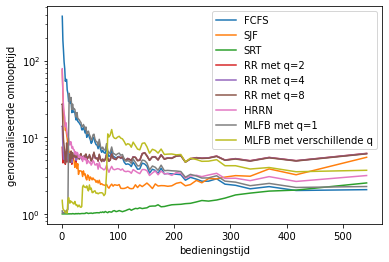

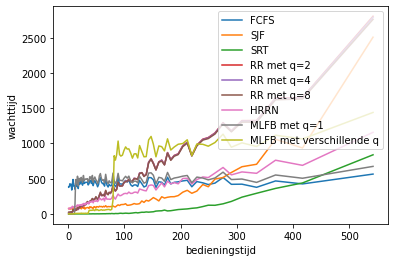

In [35]:
totaal(df_20000, "df_20000")

De tijd nodig voor fcfs te schedulen is 2.150259494781494
De tijd nodig voor SJF te schedulen is 2.0768415927886963
De tijd nodig voor SRT te schedulen is 1.6995503902435303
De tijd nodig voor RR met q=2 te schedulen is 27.456687211990356
De tijd nodig voor RR met q=4 te schedulen is 14.592657327651978
De tijd nodig voor RR met q=8 te schedulen is 8.383171796798706
De tijd nodig voor HRRN te schedulen is 3.055908441543579
De tijd nodig om MLFB1 uit te voeren is 5.4920148849487305
De tijd nodig om MLFB2 uit te voeren is 4.208568811416626


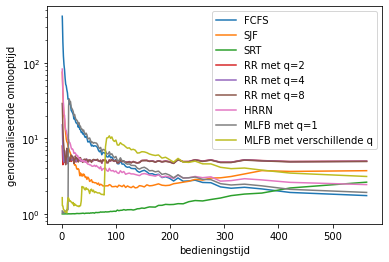

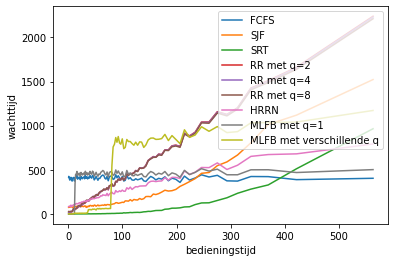

In [36]:
totaal(df_50000, "df_50000")